# **Implementation of the Model**

# Importing the data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
# Load fake news data
fake_news = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Fake.csv')
fake_news['label'] = 0  # Assign label 0 for fake news

# Load real news data
real_news = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/True.csv')
real_news['label'] = 1  # Assign label 1 for real news

# Combining and Shuffling the data

In [ ]:
data = pd.concat([fake_news, real_news]).sample(frac=1.0)   # frac 1.0 => returns all the data (rows)

# Write the combined data to a new CSV file
data.to_csv('Combined.csv', index=False)

# Preprocess Function

In [ ]:
import re
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def preprocess_text(text):
    # Replace characters that are not between a to z or A to Z with whitespace
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Convert all characters into lowercase
    text = text.lower()

    # Remove inflectional morphemes like "ed", "est", "s", and "ing" from their token stem
    text = [stemmer.stem(word) for word in text.split()]

    # Join the processed words back into a single string
    text = ' '.join(text)

    return text

# Training the Model

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

# Check if GPU is available
if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()
else:
    device_name = 'CPU:0'
print('Using device:', device_name)

# Load the dataset
data = pd.read_csv('Combined.csv')

# Preprocess the text using the preprocessing function
print("\nPreprocessing data...")

data['title_preprocessed'] = data['title'].apply(preprocess_text)

# Split the dataset into train, validation, and test sets
train_ratio = 0.64
val_ratio = 0.16
test_ratio = 0.2

print("\nSplitting Data...")

train_data = data.sample(frac=train_ratio, random_state=42)
remaining_data = data.drop(train_data.index)

val_data = remaining_data.sample(frac=val_ratio/(val_ratio+test_ratio), random_state=42)
test_data = remaining_data.drop(val_data.index)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the titles and convert them into BERT input tensors
print("\nTokenizing and Converting...")

train_inputs = tokenizer(list(train_data['title_preprocessed']), truncation=True, padding='max_length', max_length=42, return_tensors='tf')
val_inputs = tokenizer(list(val_data['title_preprocessed']), truncation=True, padding='max_length', max_length=42, return_tensors='tf')
test_inputs = tokenizer(list(test_data['title_preprocessed']), truncation=True, padding='max_length', max_length=42, return_tensors='tf')

# Convert the labels into TensorFlow tensors
train_labels = tf.convert_to_tensor(list(train_data['label']))
val_labels = tf.convert_to_tensor(list(val_data['label']))
test_labels = tf.convert_to_tensor(list(test_data['label']))

# Extract token tensors, segment tensors, and mask tensors from the BERT inputs
train_token_tensors = train_inputs['input_ids']
train_segment_tensors = train_inputs['token_type_ids']
train_mask_tensors = train_inputs['attention_mask']

val_token_tensors = val_inputs['input_ids']
val_segment_tensors = val_inputs['token_type_ids']
val_mask_tensors = val_inputs['attention_mask']

test_token_tensors = test_inputs['input_ids']
test_segment_tensors = test_inputs['token_type_ids']
test_mask_tensors = test_inputs['attention_mask']

# Build the BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Compile the model
print("\nCompiling Model...")

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train the BERT model
print("\nTraining Model...")

batch_size = 64
num_epochs = 4

history = model.fit([train_token_tensors, train_segment_tensors, train_mask_tensors], train_labels, batch_size=batch_size, epochs=num_epochs, validation_data=([val_token_tensors, val_segment_tensors, val_mask_tensors], val_labels))

# Save the trained model
print("\nSaving Model...")

model.save_pretrained('/content/bertv3_model')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Using device: /device:GPU:0

Preprocessing data...

Splitting Data...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


Tokenizing and Converting...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Compiling Model...

Training Model...
Epoch 1/4
449/449 [==============================] - 314s 580ms/step - loss: 0.1708 - accuracy: 0.9364 - val_loss: 0.0893 - val_accuracy: 0.9658
Epoch 2/4
449/449 [==============================] - 260s 578ms/step - loss: 0.0736 - accuracy: 0.9738 - val_loss: 0.0751 - val_accuracy: 0.9730
Epoch 3/4
449/449 [==============================] - 261s 582ms/step - loss: 0.0374 - accuracy: 0.9867 - val_loss: 0.0690 - val_accuracy: 0.9770
Epoch 4/4
449/449 [==============================] - 260s 580ms/step - loss: 0.0211 - accuracy: 0.9931 - val_loss: 0.0888 - val_accuracy: 0.9741

Saving Model...


# Validation

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate([test_token_tensors, test_segment_tensors, test_mask_tensors], test_labels, batch_size=batch_size)
print(f'Test loss: {loss * 100:.3f}%')
print(f'Test accuracy: {accuracy * 100:.3f}%')

141/141 [==============================] - 26s 182ms/step - loss: 0.0945 - accuracy: 0.9742
Test loss: 9.446%
Test accuracy: 97.416%


# Using the Model to predict

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# Load the saved model
model = TFBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/ColabNotebooks/bertv3_model')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example input text
input_text = input("\n\nEnter News Title: ")

# Preprocess the input text
preprocessed_text = preprocess_text(input_text)

print("Preprocessed Text:", preprocessed_text)

# Tokenize the preprocessed text
inputs = tokenizer(preprocessed_text, truncation=True, padding='max_length', max_length=42, return_tensors='tf')

# Extract input tensors
token_tensors = inputs['input_ids']
segment_tensors = inputs['token_type_ids']
mask_tensors = inputs['attention_mask']

# Make predictions
predictions = model.predict([token_tensors, segment_tensors, mask_tensors])
logits = predictions.logits[0]
probabilities = tf.nn.softmax(logits)
predicted_label = tf.argmax(probabilities)

# Print the predicted label and probabilities
if predicted_label == 0:
    print("\n*-*-Fake News-*-*")
else:
    print("\n*-*-Real News-*-*")

print("\nProbability of being fake: {:.2%}".format(probabilities[0]))
print("Probability of being real: {:.2%}".format(probabilities[1]))

Some layers from the model checkpoint at /content/drive/MyDrive/ColabNotebooks/bertv3_model were not used when initializing TFBertForSequenceClassification: ['dropout_303']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/ColabNotebooks/bertv3_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.




Enter News Title: The Government will force everyone to take a harmful and potentially lethal vaccine which they are already buying millions of doses of with our money.
Preprocessed Text: the govern will forc everyon to take a harm and potenti lethal vaccin which they are alreadi buy million of dose of with our money
1/1 [==============================] - 8s 8s/step

*-*-Fake News-*-*

Probability of being fake: 99.99%
Probability of being real: 0.01%


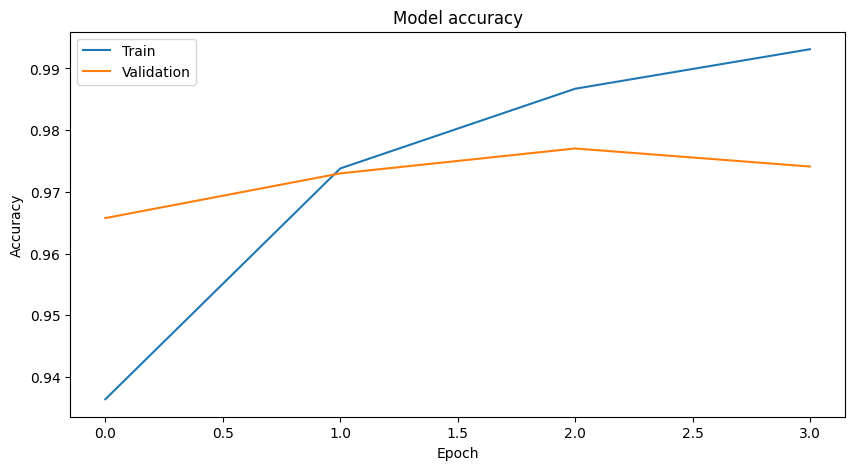

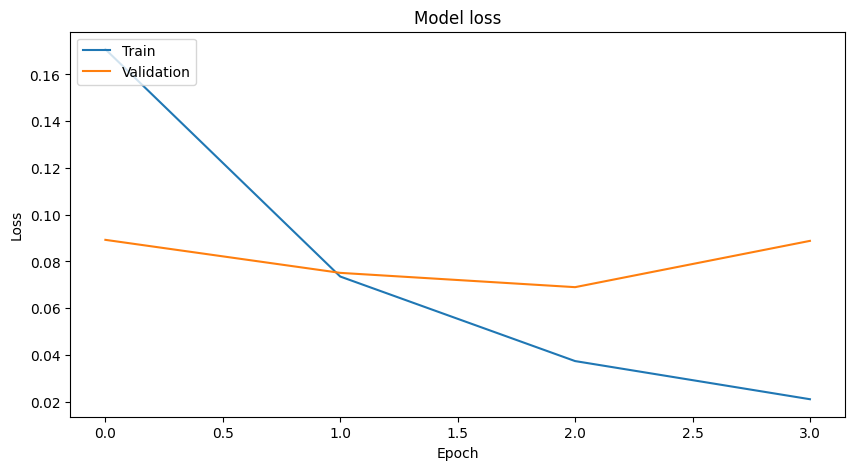

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
# Make predictions on the test set
test_predictions = model.predict([test_token_tensors, test_segment_tensors, test_mask_tensors])
test_predicted_labels = tf.argmax(tf.nn.softmax(test_predictions.logits), axis=1)
# Generate classification report
print(classification_report(test_labels, test_predicted_labels))


281/281 [==============================] - 29s 102ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4756
           1       0.98      0.96      0.97      4223

    accuracy                           0.97      8979
   macro avg       0.97      0.97      0.97      8979
weighted avg       0.97      0.97      0.97      8979

